# Mamba MCMC for an LMM with one simple, scalar term

In [1]:
addprocs(4);
Pkg.update();
using Compat,GraphViz,Mamba,RDatasets

INFO: Updating METADATA...
INFO: Updating cache of TimeSeries...
INFO: Updating cache of ArrayViews...
INFO: Updating cache of BinDeps...
INFO: Updating cache of MathProgBase...
INFO: Updating cache of Compat...
INFO: Updating cache of Distributions...
INFO: Updating cache of Images...
INFO: Updating cache of Winston...
INFO: Updating cache of SymPy...
INFO: Updating cache of Docile...
INFO: Updating cache of Cairo...
INFO: Updating cache of GZip...
INFO: Updating cache of FactCheck...


In [2]:
ds = dataset("lme4","Dyestuff");
dump(ds)

DataFrame  30 observations of 2 variables
  Batch: PooledDataArray{ASCIIString,Uint8,1}(30) ASCIIString["A","A","A","A"]
  Yield: DataArray{Int32,1}(30) Int32[1545,1440,1440,1520]


Create a `Dict{Symbol,Any}` containing the response and the indicator of the groups

In [3]:
dsdat = @compat Dict{Symbol,Any}(
:y => convert(Vector{Float64},array(ds[:Yield])),
:facs => [ds[:Batch].refs for i in 1:1],
  :K => [6],
  :X => ones(30,1),
:Z => [ones(30,1) for i in 1:1]
)

Dict{Symbol,Any} with 5 entries:
  :K    => [6]
  :Z    => […
  :X    => [1.0…
  :facs => {Uint8[1,1,1,1,1,2,2,2,2,2,3,3,3,3,3,4,4,4,4,4,5,5,5,5,5,6,6,6,6,6]}
  :y    => [1545.0,1440.0,1440.0,1520.0,1580.0,1540.0,1555.0,1490.0,1560.0,1495.…

In [4]:
b = randn(6)
β = mean(dsdat[:y])

1527.5

In [5]:
dsdat[:X]*β + b[dsdat[:facs][1]] .* dsdat[:Z][1]

30x1 Array{Float64,2}:
 1527.33
 1527.33
 1527.33
 1527.33
 1527.33
 1525.38
 1525.38
 1525.38
 1525.38
 1525.38
 1528.61
 1528.61
 1528.61
    ⋮   
 1528.1 
 1528.1 
 1528.84
 1528.84
 1528.84
 1528.84
 1528.84
 1528.19
 1528.19
 1528.19
 1528.19
 1528.19

In [16]:
dsmod = Model(
y = Stochastic(1, @modelexpr(μ,σ,MvNormal(μ,σ)),false),
σ = Logical(1, @modelexpr(logσ,exp(logσ)),true),
μ = Logical(1, @modelexpr(β,b,X,Z,facs,vec(X*β+b[:facs[1]] .* Z[1])), false)
);

In [17]:
draw(dsmod,filename="foo.dot");

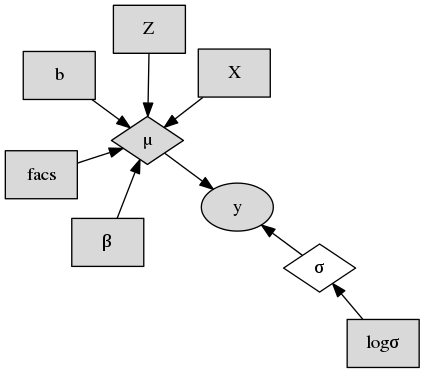

In [18]:
open("foo.dot","r") do io Graph(io) end